<a href="https://colab.research.google.com/github/pallavibekal/IISC--Parallel-Computing/blob/main/2200092_M2_NB_MiniProject_03_MLR_MPI_OpenMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Implementation of Multiple Linear Regression using MPI and OpenMP

## Learning Objectives

At the end of the mini-project, you will be able to :

* understand the collective communication operations like scatter, gather, broadcast 
* understand the blocking and non-blocking communication
* implement multiple linear regression and run it using MPI
* implement the multiple linear regression based predictions using OpenMP

### Dataset

The dataset chosen for this mini-project is [Combined Cycle Power Plant](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant). The dataset is made up of 9568 records and 5 columns. Each record contains the values for Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output. 

Predicting full load electrical power output of a base load power plant is important in order to maximize the profit from the available megawatt hours.  The base load operation of a power plant is influenced by four main parameters, which are used as input variables in the dataset, such as ambient temperature, atmospheric pressure, relative humidity, and exhaust steam pressure. These parameters affect electrical power output, which is considered as the target variable.

**Note:** The data was collected over a six year period (2006-11).

## Information

#### MPI in a Nutshell

MPI stands for "Message Passing Interface". It is a library of functions (in C / Python) or subroutines (in Fortran) that you insert into source code to perform data communication between processes. MPI was developed over two years of discussions led by the MPI Forum, a group of roughly sixty people representing some forty organizations.

To know more about MPI click [here](https://computing.llnl.gov/tutorials/mpi/#What)


#### Multiple Linear Regression

Multiple regression is an extension of simple linear regression. It is used when we want to predict the value of a variable based on the value of two or more other variables. The variable we want to predict is called the dependent variable (or sometimes, the outcome, target or criterion variable). The variables we are using to predict the value of the dependent variable are called the independent variables (or sometimes, the predictor, explanatory or regressor variables).

To know more about multiple linear regression click [here](http://mezeylab.cb.bscb.cornell.edu/labmembers/documents/supplement%205%20-%20multiple%20regression.pdf)

**Note:** We will be using the mpi4py Python package for MPI based code implementation

## Grading = 20 Points

**Run the below code to install mpi4py package**

In [ ]:
!pip install mpi4py

     |████████████████████████████████| 2.4 MB 8.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.1-cp37-cp37m-linux_x86_64.whl size=2180584 sha256=5d34e2e4e2a87925e4dc662eafcca84fdad6dbb548c8bf4a0547f0e71b36b379
  Stored in directory: /root/.cache/pip/wheels/91/be/c0/2b0347be1de5cd8ca9fe67da7ec8c3fe8930fcb6b0df6f2255
Successfully built mpi4py


#### Importing Necessary Packages

In [ ]:
# Importing pandas
import pandas as pd 
# Importing Numpy
import numpy as np 
# Importing MPI from mpi4py package
from mpi4py import MPI 
# Importing sqrt function from the Math
from math import sqrt 
# Importing Decimal, ROUND_HALF_UP functions from the decimal package
from decimal import Decimal, ROUND_HALF_UP 
import time

#### Downloading the data

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/PowerPlantData.csv

### Overview

* Load the data and perform data pre-processing
* Identify the features, target and split the data into train and test
* Implement multiple Linear Regression by estimating the coefficients on the given data
* Use MPI package to distribute the data and implement `communicator`
* Define functions for each objective and make a script (.py) file to execute using MPI command
* Use OpenMP component to predict the data and calculate the error on the predicted data
* Implement the Linear Regression from `sklearn` and compare the results

#### Exercise 1: Load data (1 point)

Write a function that takes the filename as input and loads the data in a pandas dataframe with the column names as Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output respectively.

**Hint:** read_csv()


In [ ]:
FILENAME = "/content/PowerPlantData.csv" # File path

def load_data(path):
  return pd.read_csv(path).rename(columns={'AT': 'Ambient Temperature', 'V': 'Exhaust Vaccum', 'AP': 'Ambient Pressure', 
                                           'RH': 'Relative Humidity', 'PE': 'Energy Output'})

data_init = load_data(FILENAME)

#### Exercise 2: Explore data (1 point)

Write a function that takes the data loaded using the above defined function as input and explore it.

**Hint:** You can define and check for following things in the dataset inside a function

- checking for the number of rows and columns
- summary of the dataset
- check for the null values 
- check for the duplicate values

In [ ]:
def data_explore(df):
  print( 'No of rows - ', df.shape[0])
  print( 'No of Columns -', df.shape[1])
  print('---------------------')
  print('Info')
  print('---------------------')
  print(df.info())
  print('---------------------')
  print(df.describe())
  print('---------------------')
  print('Null Values')
  print(df.isnull().sum())
  print('---------------------')
  print('Duplicate Values')
  print('---------------------')
  print(df.duplicated(subset=None,keep='first').sum())


data_explore(data_init)

No of rows -  9568
No of Columns - 5
---------------------
Info
---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ambient Temperature  9568 non-null   float64
 1   Exhaust Vaccum       9568 non-null   float64
 2   Ambient Pressure     9568 non-null   float64
 3   Relative Humidity    9568 non-null   float64
 4   Energy Output        9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
None
---------------------
       Ambient Temperature  Exhaust Vaccum  ...  Relative Humidity  Energy Output
count          9568.000000     9568.000000  ...        9568.000000    9568.000000
mean             19.651231       54.305804  ...          73.308978     454.365009
std               7.452473       12.707893  ...          14.600269      17.066995
min               1.810000       25.360000  ...          25.5

#### Exercise 3: Handle missing data (1 point)

After exploring the dataset if there are any null values present in the dataset then define a function that takes data loaded using the above defined function as input and handle the null values accordingly.

**Hint:** 

- Drop the records containing the null values - dropna()
- Replace the null values with the mean/median/mode - fillna()

In [ ]:
# Function to handle missing data

def missing_datadrop(df):
  return df.dropna()

# we will not use this function as our data does not have any missing data

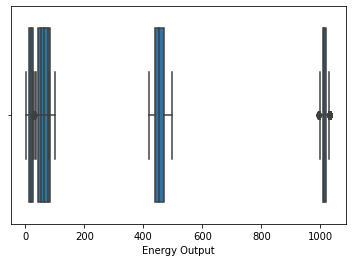

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#df = file_check(FILENAME,col_names)
for i in range(0,data_init.shape[1]):
  sns.boxplot(x=data_init.columns[i], data=data_init)


#### Exercise 4: Scale the data (1 point)

Write a function that takes the data after handling the missing data as input and returns the standardized data.

**Hint:**

- standardization of the data  can be performed using the below formula

$ (x - mean(x)) / std(x) $ 

In [ ]:
# Defining a function to standardize the data

def scale_data(df):
  df = (df- df.mean())/df.std()
  return df

data_scaled = scale_data(data_init)
data_scaled.head()

,Ambient Temperature,Exhaust Vaccum,Ambient Pressure,Relative Humidity,Energy Output
0,-1.517782,-1.065149,-0.407336,1.143885,1.530146
1,0.535228,0.329260,-0.313040,0.061028,-0.504776
2,1.353748,0.204141,-1.028675,-2.150575,-0.914338
3,-0.077992,-0.363223,-1.016888,0.238422,-0.074706
4,-1.053507,-1.073805,0.651804,1.636341,0.589734


#### Exercise 5: Feature selection (1 point)

Write a function that takes scaled data as input and returns the features and target variable values

**Hint:**

- Features: AmbientTemperature, ExhaustVaccum, AmbientPressure, RelativeHumidity 
- Target Variable: EnergyOutput

In [ ]:
# Define a function

def get_feature_target(df):
  features = ['Ambient Temperature','Exhaust Vaccum', 'Ambient Pressure', 'Relative Humidity']
  target = ['Energy Output']

  X = df[features]
  y = df[target]
  return X,y

X,y = get_feature_target(data_scaled)

In [ ]:
X.head()

,Ambient Temperature,Exhaust Vaccum,Ambient Pressure,Relative Humidity
0,-1.517782,-1.065149,-0.407336,1.143885
1,0.535228,0.329260,-0.313040,0.061028
2,1.353748,0.204141,-1.028675,-2.150575
3,-0.077992,-0.363223,-1.016888,0.238422
4,-1.053507,-1.073805,0.651804,1.636341


#### Exercise 6: Correlation (1 point)

Calculate correlation between the variables

In [ ]:
X.corr()

,Ambient Temperature,Exhaust Vaccum,Ambient Pressure,Relative Humidity
Ambient Temperature,1.000000,0.844107,-0.507549,-0.542535
Exhaust Vaccum,0.844107,1.000000,-0.413502,-0.312187
Ambient Pressure,-0.507549,-0.413502,1.000000,0.099574
Relative Humidity,-0.542535,-0.312187,0.099574,1.000000


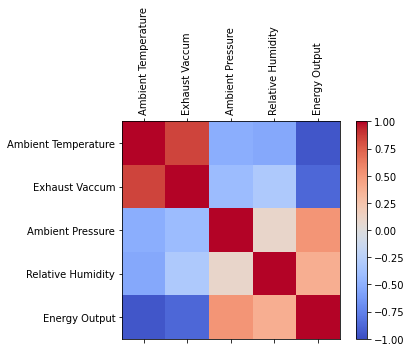

In [ ]:
corr = data_scaled.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap = 'coolwarm',vmin = -1,vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0,len(data_scaled.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation = 90)
ax.set_yticks(ticks)
ax.set_xticklabels(data_scaled.columns)
ax.set_yticklabels(data_scaled.columns)
plt.show()


#### Exercise 7: Estimate the coefficients (2 points)

Write a function that takes features and target as input and returns the estimated coefficient values

**Hint:**

- Calculate the estimated coefficients using the below formula

$ β = (X^T X)^{-1} X^T y $ 

- transpose(), np.linalg.inv()

In [ ]:
# Calculating the coeffients

def least_squares(X,y):
    xtx = np.dot(X.T, X) ## x-transpose times x
    inv_xtx = np.linalg.inv(xtx) ## inverse of x-transpose times x
    xty = np.dot(X.T, y) ## x-transpose times y
    return np.dot(inv_xtx, xty)

params = least_squares(X,y)
print(params)


[[-0.86350078]
 [-0.17417154]
 [ 0.02160293]
 [-0.13521023]]


#### Exercise 8: Fit the data to estimate the coefficients (2 points)

Write a function named fit which takes features and targets as input and returns the intercept and coefficient values.

**Hint:**

- create a dummy column in the features dataframe which is made up of all ones
- convert the features dataframe into numpy array
- call the estimated coefficients function which is defined above
- np.ones(), np.concatenate()

In [ ]:
# defining a fit function
def fit(x, y):
    array = x.to_numpy()
    array_ones = np.ones((x.shape[0],1))
    #print(array.shape)
    #print(array_ones.shape)
    array_new = np.concatenate((array_ones,array), axis=1)
    #print(array_new.shape)
    params = least_squares(array_new,y)
    return params, pd.DataFrame(array_new)

params,X_new = fit(X,y)
print(params)


[[-5.22225116e-14]
 [-8.63500780e-01]
 [-1.74171544e-01]
 [ 2.16029345e-02]
 [-1.35210234e-01]]


#### Exercise 9: Predict the data on estimated coefficients (1 point)

Write a function named predict which takes features, intercept and coefficient values as input and returns the predicted values.

**Hint:**

- Fit the intercept, coefficients values in the below equation

  $y = b_0 + b_1*x + ... + b_i*x_i$

In [ ]:
 # fucntion to predict the values
def predict(x, params):
    '''
    y = b_0 + b_1*x + ... + b_i*x_i
    '''
  
    y_pred1 = np.dot(x,params)
    
    return y_pred1

y_pred = predict(X_new,params)
y_pred.shape

(9568, 1)

#### Exercise 10: Root mean squared error (1 point)

Write a function to calculate the RMSE error. 

**Hint:**

- [How to calculate the RSME error](https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e)

In [ ]:
# Define a function to calculate the error

def rmse(y,y_pred):
  diff = (((y-y_pred)**2)/y.shape[0]).sum()
  return diff**0.5

error_rmse = rmse(y.to_numpy(),y_pred)
print(error_rmse)

0.26701396565722224


#### Exercise 11: Split the data into train and test (1 point)

Write a function named train_test_split which takes features and targets as input and returns the train and test sets respectively.

**Hint:**

- Shuffle the data
- Consider 70 % of data as a train set and the rest of the data as a test set

In [ ]:
def train_test_split_in(x,y,percent_split):
  df = pd.concat([x,y],axis=1)
  len_df = df.shape[0]
  len_split1 = int(round(len_df * percent_split,0))

  df_shuffled = df.sample(frac=1)
  df_train = df.iloc[:len_split1,:]
  df_test = df.iloc[len_split1:,:]

  df_train_X = df_train.iloc[:,0:4]
  df_train_y = df_train.iloc[:,4:5]
  df_test_X = df_test.iloc[:,0:4]
  df_test_y = df_test.iloc[:,4:5]
  return df_train_X, df_train_y, df_test_X, df_test_y


X_train, y_train, X_test, y_test = train_test_split_in(X,y,0.7)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



(6698, 4)
(6698, 1)
(2870, 4)
(2870, 1)


#### Exercise 12: Create a communicator (1 point)

Create a comunicator and define the rank and size

In [ ]:
%%writefile commfirst.py
def main():
  from mpi4py import MPI

  comm = MPI.COMM_WORLD
  size = comm.Get_size()
  rank = comm.Get_rank()
  name = MPI.Get_processor_name()
  print("Hello, I am rank %d of %d" %(rank,size))

main()


Overwriting commfirst.py


In [ ]:
!mpirun --allow-run-as-root -np 2 python commfirst.py

Hello, I am rank 0 of 2
Hello, I am rank 1 of 2


#### Exercise 13: Divide the data into slices (1 point)

Write a function named dividing_data which takes train features set, train target set, and size of workers as inputs and returns the sliced data for each worker.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/MiniProject_MPI_DataSlice.JPG)

For Example, if there are 4 processes, slice the data into 4 equal parts with 25% ratio

**Hint:**

- Divide the Data equally among the workers
  - Create an empty list
  - Iterate over the size of workers
  - Append each slice of data to the list

In [ ]:
def dividing_data(x_train, y_train, size_of_workers):
    # Size of the slice
    slice_for_each_worker = int(Decimal(x_train.shape[0]/size_of_workers).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))      
    print('Slice of data for each worker: {}'.format(slice_for_each_worker))
    
    listx = []
    listy = []
    start = 0
    end = slice_for_each_worker
    for i in range(size_of_workers):
      data_slicex = 0
      data_slicey = 0
      if i == size_of_workers -1: 
        data_slicex = x_train.iloc[start:,:]
        data_slicey = y_train.iloc[start:]
      else:
        data_slicex = x_train.iloc[start:end,:]
        data_slicey = y_train.iloc[start:end]
      listx.append(data_slicex.to_numpy())
      listy.append(data_slicey.to_numpy())
      start = end
      end = end + slice_for_each_worker
    return listx, listy

list_dumx, list_dumy = dividing_data(X_train, y_train, 3)




Slice of data for each worker: 2233


In [ ]:
#print(list_dumx[0].shape[0]*list_dumx[0].shape[1])
print(list_dumy[0].shape)
print(type(list_dumx))
print(type(list_dumx[0]))
print(type(list_dumy[0]))


(2233, 1)
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(type(list_dumx[0]))

<class 'numpy.ndarray'>


#### Exercise 14: Prepare the data in root worker to assign data for all the workers (1 point)

- When it is the root worker, perform the below operation:
    - Store the features and target values in separate variables
    - Split the data into train and test sets using the train_test_split function defined above
    - Divide the data among the workers using the dividing_data function above

In [ ]:
%%writefile lrtestscatter.py

def load_data(path):
  return pd.read_csv(path).rename(columns={'AT': 'Ambient Temperature', 'V': 'Exhaust Vaccum', 'AP': 'Ambient Pressure', 
                                           'RH': 'Relative Humidity', 'PE': 'Energy Output'})

def data_explore(df):
  print( 'No of rows - ', df.shape[0])
  print( 'No of Columns -', df.shape[1])
  print('---------------------')
  print('Info')
  print('---------------------')
  print(df.info())
  print('---------------------')
  print('Null Values')
  print(df.isnull().sum())
  print('---------------------')
  print('Duplicate Values')
  print('---------------------')
  print(df.duplicated(subset=None,keep='first').sum())

def scale_data(df):
  df = (df- df.mean())/df.std()
  return df

def get_feature_target(df):
  features = ['Ambient Temperature','Exhaust Vaccum', 'Ambient Pressure', 'Relative Humidity']
  target = ['Energy Output']

  X = df[features]
  y = df[target]
  return X,y

def least_squares(X,y):
    xtx = np.dot(X.T, X) ## x-transpose times x
    inv_xtx = np.linalg.inv(xtx) ## inverse of x-transpose times x
    xty = np.dot(X.T, y) ## x-transpose times y
    return np.dot(inv_xtx, xty)

def fit(x, y):
    array = x
    array_ones = np.ones((x.shape[0],1))
    #print(array.shape)
    #print(array_ones.shape)
    array_new = np.concatenate((array_ones,array), axis=1)
    #print(array_new.shape)
    params = least_squares(array_new,y)
    return params, pd.DataFrame(array_new)

def predict(x, params):
    '''
    y = b_0 + b_1*x + ... + b_i*x_i
    '''
  
    y_pred1 = np.dot(x,params)
    
    return y_pred1

def rmse(y,y_pred):
  diff = (((y-y_pred)**2)/y.shape[0]).sum()
  return diff**0.5

def train_test_split_in(x,y,percent_split):
  df = pd.concat([x,y],axis=1)
  len_df = df.shape[0]
  len_split1 = int(round(len_df * percent_split,0))

  df_shuffled = df.sample(frac=1)
  df_train = df.iloc[:len_split1,:]
  df_test = df.iloc[len_split1:,:]

  df_train_X = df_train.iloc[:,0:4]
  df_train_y = df_train.iloc[:,4:5]
  df_test_X = df_test.iloc[:,0:4]
  df_test_y = df_test.iloc[:,4:5]
  return df_train_X, df_train_y, df_test_X, df_test_y

def dividing_data(x_train, y_train, size_of_workers):
    # Size of the slice
    slice_for_each_worker = int(Decimal(x_train.shape[0]/size_of_workers).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))      
    print('Slice of data for each worker: {}'.format(slice_for_each_worker))
    
    listx = []
    listy = []
    start = 0
    end = slice_for_each_worker
    for i in range(size_of_workers):
      data_slicex = 0
      data_slicey = 0
      if i == size_of_workers -1: 
        data_slicex = x_train.iloc[start:,:]
        data_slicey = y_train.iloc[start:]
      else:
        data_slicex = x_train.iloc[start:end,:]
        data_slicey = y_train.iloc[start:end]
      listx.append(data_slicex.to_numpy())
      listy.append(data_slicey.to_numpy())
      start = end
      end = end + slice_for_each_worker
    return listx, listy

def main():
  #creating a communicator
  comm = MPI.COMM_WORLD
  #number of processes running the code
  rank = comm.Get_rank()
  size = comm.Get_size()
  data_x = None
  data_y = None
  params = None
  if rank == 0:
    # Load Data
    FILENAME = "/content/PowerPlantData.csv" # File path
    data_init = load_data(FILENAME)
    # Explore Data
    print(data_explore(data_init))
    # Scale Data
    data_scaled = scale_data(data_init)
    # Get Features
    X,y = get_feature_target(data_scaled)
    # Train Test Split
    X_train, y_train, X_test, y_test = train_test_split_in(X,y,0.7)
    # Divide the data 
    data_x, data_y = dividing_data(X_train, y_train, size)
 
  data_x = comm.scatter(data_x, root=0)
  data_y = comm.scatter(data_y, root=0)
  # Calculate the coefficients for each slice of data
  params,X_new = fit(data_x,data_y)
  params = comm.gather(params,root=0)

  if rank == 0:
    print('Process {} has data:'.format(rank), params)
    # Predict target for test data using mean of params from each process
    params_train = np.mean(params,axis=0)
    params_test, X_test_new = fit(X_test,y_test)
    y_pred_new = predict(X_test_new,params_train)
    error_rmse = rmse(y_test,y_pred_new)
    print('Process{} has data:'.format(rank),params_train)
    print('Process {} has data:'.format(rank), error_rmse)

import pandas as pd 
# Importing Numpy
import numpy as np 
# Importing MPI from mpi4py package
from mpi4py import MPI 
# Importing sqrt function from the Math
from math import sqrt 
# Importing Decimal, ROUND_HALF_UP functions from the decimal package
from decimal import Decimal, ROUND_HALF_UP 
import time

main()






Overwriting lrtestscatter.py


In [ ]:
! mpirun --allow-run-as-root -np 3 python lrtestscatter.py

No of rows -  9568
No of Columns - 5
---------------------
Info
---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ambient Temperature  9568 non-null   float64
 1   Exhaust Vaccum       9568 non-null   float64
 2   Ambient Pressure     9568 non-null   float64
 3   Relative Humidity    9568 non-null   float64
 4   Energy Output        9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
None
---------------------
Null Values
Ambient Temperature    0
Exhaust Vaccum         0
Ambient Pressure       0
Relative Humidity      0
Energy Output          0
dtype: int64
---------------------
Duplicate Values
---------------------
41
None
Slice of data for each worker: 2233
Process 0 has data: [array([[ 0.00405002],
       [-0.85879604],
       [-0.16402858],
       [ 0.02233545],
       [-0.12673205]]), a

#### Exercise 15: Scatter and gather the data (1 point)

Perform the below operations:

- Send slices of the training set(the features data X and the expected target data Y) to every worker including the root worker
    - **Hint:** scatter()
    - use `barrier()` to block workers until all workers in the group reach a Barrier, to scatter from root worker.
- Every worker should get the predicted target Y(yhat) for each slice
- Get the new coefficient of each instance in a slice
    - **Hint:** fit function defined above
- Gather the new coefficient from each worker
    - **Hint:** gather()
- Calculate the root mean square error for the test set

To know more about `scatter`, `gather` and `barrier` click [here](https://nyu-cds.github.io/python-mpi/05-collectives/)

In [ ]:
# YOUR CODE HERE

#### Exercise 16: Make a script and execute everything in one place (1 point)

Write a script(.py) file which contains the code of all the above exercises in it so that you can run the code on multiple processes using MPI.

**Hint:**

- magic commands
- put MPI related code under main function
- !mpirun --allow-run-as-root -np 4 python filename.py

In [ ]:
# YOUR CODE HERE for scipt(.py) 

In [ ]:
# YOUR CODE HERE for MPI command

#### Exercise 17: Implement predict using OpenMP (1 point)

Get the predictions for test data and calculate the test error(RMSE) by implementing the OpenMP (pymp)

**Hints:**

* Using the pymp.Parallel implement the predict function (use from above)

* Call the predict function by passing test data as an argument

* calculate the error (RMSE) by comparing the Actual test data and predicted test data

In [ ]:
!pip install pymp-pypi

In [ ]:
import pymp
test_data_x = pymp.shared.array((X_test.shape), dtype='uint8')
test_data_x = X_test # From Exercise 11 using custom test train split

# Use OPEN MP for implementing predict function


with pymp.Parallel(4) as p:
  def parallel_predict(x, params):
    '''
    y = b_0 + b_1*x + ... + b_i*x_i
    '''  
    array = x

    array_ones = np.ones((x.shape[0],1))

    array_new = np.concatenate((array_ones,array), axis=1)

    y_pred1 = np.dot(array_new,params)
    
    return y_pred1

  # Calculate predicted values on test_data

  start_time=time.perf_counter()
  y_pred=parallel_predict(test_data_x,params)
  end_time = time.perf_counter()

print("Time Elapsed", end_time - start_time)

#p.close()


# Calculate RMSE
print("RMSE ",rmse(y_test,y_pred))

Time Elapsed 0.00046772300083830487
RMSE  Energy Output    0.264012
dtype: float64


In [ ]:
def predict_pmp(x, params):
    '''
    y = b_0 + b_1*x + ... + b_i*x_i
    '''
    array = x

    array_ones = np.ones((x.shape[0],1))

    array_new = np.concatenate((array_ones,array), axis=1)

    y_pred1 = np.dot(array_new,params)
    
    return y_pred1


In [ ]:
# Test using regular predict function

start_time=time.perf_counter()
y_pred=predict_pmp(X_test,params)
end_time = time.perf_counter()

print("Time Elapsed", end_time - start_time)
print("RMSE ",rmse(y_test,y_pred))

Time Elapsed 0.0065912190002563875
RMSE  Energy Output    0.264012
dtype: float64


#### Exercise 18: Use Sklearn to compare (1 point)

Apply the Linear regression on the given data using sklearn package and compare with the above results

**Hint:**
* Split the data into train and test
* Fit the train data and predict the test data using `sklearn Linear Regression`
* Compare the coefficients and intercept with above estimated coefficients
* calculate loss (RMSE) on test data and predictions and compare

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



SKL1 = LinearRegression()



data_scaled = scale_data(data_init)
X,y = get_feature_target(data_scaled)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=42,shuffle=True)
SKL1.fit(np.array(X_train),y_train)

# Check the co-efficents from our LinearRegression Class and sklearns
print('SKlearn  Linear Regression Co-efficient is : ',SKL1.coef_,SKL1.intercept_)

y_pred = SKL1.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE Error:", rmse)



SKlearn  Linear Regression Co-efficient is :  [[-0.87481436 -0.16774442  0.02299454 -0.13255654]] [-0.00826965]
RMSE Error: 0.26839497882117186
